Choisir un minimum de durée de parole, ou bien un maximum de speech rate pour supprimer les erreurs, car il y en a. Se baser sur un record mondial ? Ou tracer la distribution par intervalle pour voir à partir de quand c'est anecdotique ?
Problèmes parfois dus à un recouvrement des paroles et  notre hypothèse sur leur enchainement direct

Les valeurs extrêmes sont dues à des erreurs dans les temps de la transcription.


Pour AA LD BF : du à une erreur sur le beginning time (trop tard donc trop court)

Pour AA JL AZ : beginning time trop tard aussi (mais seulement ça ?)

Pour AA AN DL : pareil

Pour CA MB LB : pareil



In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
import re
from sklearn.linear_model import LinearRegression 

In [3]:
lexicon = pd.read_csv('/home/inous/Documents/S2/INRIA/LEXIQUE/Lexique383/Lexique383.tsv', sep='\t')
lexicon = lexicon[['ortho', 'nbsyll']]
dictionnary = dict(zip(lexicon['ortho'], lexicon ['nbsyll']))

In [4]:
def importer_csv(my_path):
    pathlist = Path(my_path).glob('**/*.csv')
    data = []
    file_names = []
    for path in pathlist:
        print(path)
        data.append(pd.read_csv(path))
        file_names.append(str(path)[-12:-4])
    return file_names, data

In [5]:
def estimate_syllables(nom) : #for french names that at not in the lexicon
    vowels = ['a', 'e', 'é', 'è', 'à','i', 'o', 'u', 'y']
    nb = 0
    for character in nom:
        if character in vowels:
            nb+=1
    return nb

In [6]:
def nb_syllables(string):
    if type(string)==str:
        string = string.lower()
        symbols=[',', ';', '\.', '!', '\?']
        confusing_strings = ("m'", "t'", "c'", "s'", "d'", "j'", "l'", "n'")
        for symbol in symbols:
            string = re.sub(symbol, " ",string)
        for conf in confusing_strings:
            string = re.sub(conf, " ", string)
        nb = 0
        string_words = re.split(' ', string)
        for wanted_word in string_words:
            if wanted_word !='' :
                if wanted_word in dictionnary:
                    syll_word = dictionnary[wanted_word]
                else : 
                    syll_word = estimate_syllables(wanted_word)
                nb += syll_word
        return nb
    else:
        return None

In [7]:
print(nb_syllables("Bravo ! Bien c'était bien un anniversaire, c'est ça? Tu vois que tu es arriver quand même ? Bon, alors eh, attends j'vais demander à la dame est-ce que je fais on fait euhm,un dernier test ou essayer de deviner un mot pour lui? Ou est ce que je passe à la deuxième partie? Alors donc euh,  c'est parti, c'est toi qui cherche le mot dans ta tête, ma chérie."))

92


In [8]:
def repare_time(string):
    if type(string) != str:
        print("c'est bien une string : ", string)
        string = str(string)
    index = [] #là où on mettra les ':'
    j=1
    while j<len(string)-2 and string[j+2]!='.':
        if j%2==1:
            index.append(j)
        j+=1
    for position in index[::-1]:
        string = string[:position+1] + ':' + string[position+1:]
    return string

In [9]:
def conversion_time(strings):
    if type(strings)==str:
        
        string = strings
        if ':' not in string:
            string = repare_time(string)
        string = re.split(':', string)
        if len(string) >= 2:
            seconds_str, minutes_str = string[-1], string[-2]
            seconds, minutes = float(seconds_str), float(minutes_str)
            time = seconds/60 + minutes
        else:
            print("trop court pour séparer", string)
    elif (type(strings) == int or type(strings)== float) and strings <= 2000 :
        time = strings/60  #c'est en secondes
    elif (type(strings) ==int or type(strings) == float) and strings > 2000 : 
        strings = repare_time(strings)
        strings = conversion_time(strings)
        time = strings
    else:
        time=[]
        for string in strings :
            if type(string)==str:
                if ':' not in string:
                    string = repare_time(string)
                string = re.split(':', string)
                if len(string) >= 2:
                    seconds_str, minutes_str = string[-1], string[-2]
                    seconds, minutes = float(seconds_str), float(minutes_str)
                    time.append(seconds/60 + minutes)
                else:
                    print("trop court pour séparer")
            elif (type(string) == int or type(string)== float) and string <= 2000:
                time.append(string/60) #c'est en secondes
            elif (type(string) == int or type(string)== float) and string > 2000:
                string = repare_time(string)
                string = conversion_time(string)
                time.append(string)
            else:
                print(type(string))
    return time

In [10]:
#conversation est un DataFrame d'interventions
#renvoie une liste d'intervenants (O ou 1)
#dans le cas CA,(type_conv='CA'), 0 pour adulte et 1 pour enfant

def extract_speakers(type_conv, conversation):
    
    speaker_list = []
    
    if type_conv =='AA':
        speaker1 = conversation['speaker'][0]
        
    else:  #on veut que le speaker noté par 0 soit l'adulte
        k=0
        speaker = conversation['speaker'][k]
        while speaker not in adult_speakers and k < len(conversation['speaker']) :
            k+=1
            speaker = conversation['speaker'][k]
            
        speaker1 = speaker  #c'est l'adulte
    
    for j in range(len(conversation['speaker'])):
        if conversation['speaker'][j]==speaker1:
            speaker_list.append(0)
        else:
            speaker_list.append(1)
            
    return speaker_list

In [11]:
def compute_ending_time(conversation):
    ending_time = []
    for i in range(len(conversation['starting time'])-1):
        ending_time.append(conversation['starting time'][i+1])
    return ending_time

In [12]:
def compute_duration(conversation):
    duration_list = []
    for i in range(len(conversation['starting time'])-1):
        delta_t = conversation['ending time'][i]-conversation['starting time'][i]
        duration_list.append(delta_t)
    duration_list.append(np.mean(duration_list))
    return duration_list

In [13]:
def compute_speech_rate(conversation):
    speech_rate_list = []
    for i in conversation.index:
        speech_rate_list.append( conversation["nb_syllables"][i]/conversation['duration'][i] )
    return speech_rate_list

In [14]:
def compute_difference_speech_rate(conversation):
    
    index_time = []
    diff = []
    speaker = []
    
    speaker1 = conversation['speaker'][0]
    
    i=0
    while conversation['speaker'][i] == speaker1:
        i+=1
    speaker2 = conversation['speaker'][i]
    
    for i in range(1,len(conversation['speech rate'])):
            
            delta_speech_rate = conversation.loc[i]['speech rate'] - conversation.loc[i-1]['speech rate']

            if conversation.loc[i-1]['speaker'] == speaker1 and conversation.loc[i]['speaker'] == speaker2 :
                speaker.append(1)

            elif conversation.loc[i-1]['speaker'] == speaker2 and conversation.loc[i]['speaker'] == speaker1 :
                speaker.append(0)
            index_time.append(i)
            diff.append(delta_speech_rate)
            
    time = conversation['starting time'][index_time]
            
    result = pd.DataFrame(list(zip(time, diff, speaker)), columns = ['time', 'delta', 'speaker'])
            
    return result

In [15]:
alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
min_len_speech = 1/60 #in minutes
max_speech_rate = float('inf')

In [16]:
Speakers = ['Répondant', 'Modérateur', 'Interviewer', 'Interviewee', 'Intervieweur', "L'interviewé", 'Interviewé','Speaker1','Isaac', 'Parent', 'Enfant', 'Papa', 'Léon', 'Speaker2']
Adult_speakers = ['Modérateur', 'Interviewer','Intervieweur','Parent',  'Papa']
Child_speakers = ['Répondant','Interviewee', "L'interviewé", 'Interviewé','Isaac', 'Enfant','Léon']

In [17]:
file_names_AA, data_AA = importer_csv("/home/inous/Documents/S2/INRIA/OUTPUT/CSV_TRANSCRIPTIONS/AA")
file_names_CA, data_CA = importer_csv("/home/inous/Documents/S2/INRIA/OUTPUT/CSV_TRANSCRIPTIONS/CA")

/home/inous/Documents/S2/INRIA/OUTPUT/CSV_TRANSCRIPTIONS/AA/AA-LD-BF.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_TRANSCRIPTIONS/AA/AA-MG-CH.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_TRANSCRIPTIONS/AA/AA-MJ-CJ.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_TRANSCRIPTIONS/AA/AA-JL-AZ.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_TRANSCRIPTIONS/AA/AA-BO-CM.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_TRANSCRIPTIONS/AA/AA-GD-DD.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_TRANSCRIPTIONS/AA/AA-XA-EH.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_TRANSCRIPTIONS/AA/AA-AN-DL.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_TRANSCRIPTIONS/AA/AA-ML-MP.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_TRANSCRIPTIONS/AA/AA-LA-AN.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_TRANSCRIPTIONS/CA/CA-XA-LA.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_TRANSCRIPTIONS/CA/CA-MB-LB.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_TRANSCRIPTIONS/CA/CA-LJ-MJ.csv
/home/inous/Documents/S2/INRIA/OUTPUT/CSV_TRANSCRIP

In [18]:
%time

# calculating new columns

for k,conversation in enumerate(data_AA):
    
    print(file_names_AA[k])

    conversation['speaker'] = extract_speakers('AA',conversation)
    
    ending_time_list = compute_ending_time(conversation)
    conversation.drop( conversation.tail(1).index, inplace = True)
    conversation['ending time'] = ending_time_list

    conversation['starting time'] = conversion_time(conversation['starting time'])
    conversation['ending time'] = conversion_time(conversation['ending time'])
    
    conversation['nb_syllables'] = np.vectorize(nb_syllables)( conversation['words'])
    for i,nb_syll in enumerate(conversation['nb_syllables']):
        if nb_syll == None:
            print("Voici la ligne qui pose problème : ",conversation['words'][i], type(conversation['words'][i]))
            print("et ça donne :",nb_syllables(conversation['words'][i]))

    conversation['duration'] = compute_duration(conversation)
    conversation = conversation [ conversation['duration'] !=0 ]
    
    conversation['speech rate'] = compute_speech_rate(conversation)
    
    conversation = conversation [ conversation['duration'] >= min_len_speech]  #on enlève les interventions trop courtes, donne un speech rate énorme
    conversation = conversation [ conversation['speech rate'] <= max_speech_rate]
    data_AA[k] = conversation
    
    data_AA[k].reset_index(drop=True, inplace=True)


CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 16.7 µs
AA-LD-BF
AA-MG-CH
AA-MJ-CJ
AA-JL-AZ
AA-BO-CM
AA-GD-DD
AA-XA-EH
AA-AN-DL
AA-ML-MP
AA-LA-AN


/tmp/ipykernel_7371/2139210208.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conversation['speech rate'] = compute_speech_rate(conversation)
/tmp/ipykernel_7371/2139210208.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  conversation['speech rate'] = compute_speech_rate(conversation)
/tmp/ipykernel_7371/2139210208.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [19]:
data_AA[0][:15]

,Unnamed: 0,speaker,starting time,words,ending time,nb_syllables,duration,speech rate
0,0,0,0.000000,Heu pin.,0.066667,2,0.066667,30.000000
1,1,1,0.066667,Oui,0.100000,1,0.033333,30.000000
2,2,0,0.100000,C'est bon ? c'est fait il faut que tu sois e...,0.166667,13,0.066667,195.000000
3,3,1,0.166667,Okay.,0.200000,3,0.033333,90.000000
4,4,0,0.200000,"Voilà. Donc on va commencer, je vais t'expli...",0.266667,16,0.066667,240.000000
5,6,0,0.283333,"Donc tu dois me faire, enfin on doit se fair...",0.466667,50,0.183333,272.727273
6,8,0,0.483333,On va faire ça pendant 10-12 minutes et aprè...,0.650000,24,0.166667,144.000000
7,9,1,0.650000,D'accord.,0.683333,2,0.033333,60.000000
8,10,0,0.683333,Tu veux commencer ou je commence ?,0.716667,9,0.033333,270.000000
9,12,0,0.733333,"Okay,bein, j'suis prête.",0.800000,7,0.066667,105.000000


In [22]:
#nom du fichier, indice du max speech rate, mots correspondants

#for k, conversation in enumerate(data_AA):
    #print(file_names_AA[k])
    #print(max(conversation['speech rate']))
    #print(conversation[ conversation['speech rate'] == max(conversation['speech rate']) ]['words'])

0


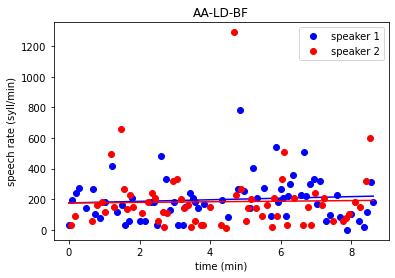

1


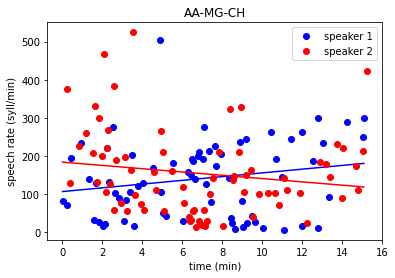

2


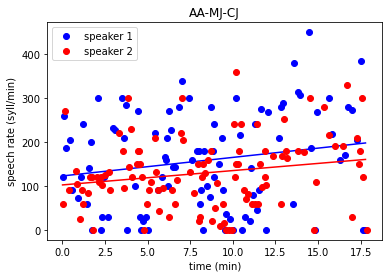

3


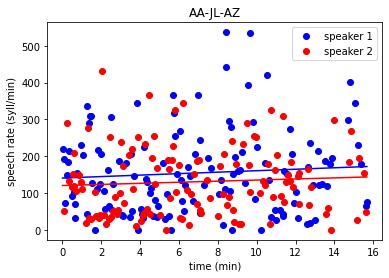

4


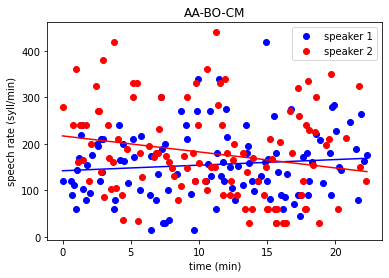

5


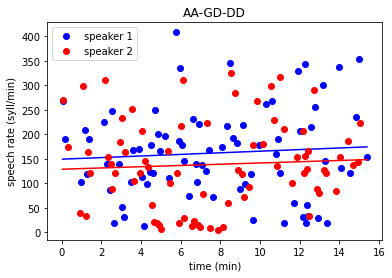

6


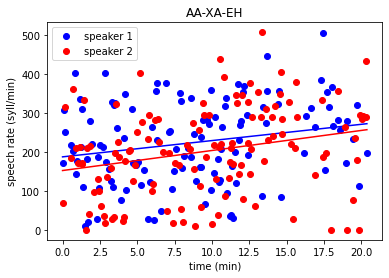

7


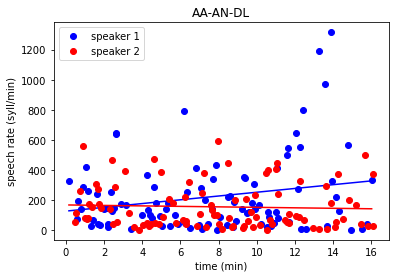

8


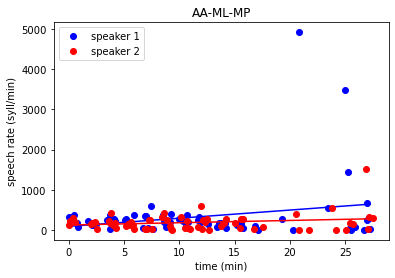

9


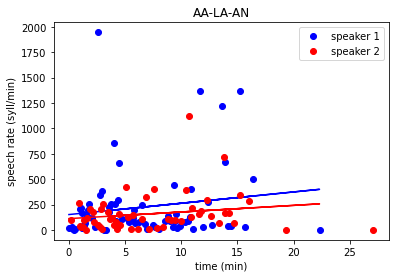

In [23]:
for k,conversation in enumerate(data_AA):
    
    print(k)
    #print(conversation.head())

    #for speaker 1
    
    speech_1 = conversation[conversation['speaker']==0][['starting time', 'speech rate']]    
    
    linear_reg_AA_1 = LinearRegression(normalize=True)
    
    x_1 = np.array(speech_1['starting time'])
    x_1 = x_1.reshape(-1,1)

    y_1 = np.array(speech_1['speech rate'])
    y_1 = y_1.reshape(-1,1)
    
    linear_reg_AA_1.fit(x_1, y_1)
    
    a_AA_1 = linear_reg_AA_1.coef_[0][0]
    b_AA_1 = linear_reg_AA_1.intercept_[0]
    
    #for speaker 2
    
    speech_2 = conversation[conversation['speaker']==1][['starting time', 'speech rate']]

    linear_reg_AA_2 = LinearRegression(normalize=True)
    
    x_2 = np.array(speech_2['starting time'])
    x_2 = x_2.reshape(-1,1)

    y_2 = np.array(speech_2['speech rate'])
    y_2 = y_2.reshape(-1,1)
    
    linear_reg_AA_2.fit(x_2, y_2)
    
    a_AA_2 = linear_reg_AA_2.coef_[0][0]
    b_AA_2 = linear_reg_AA_2.intercept_[0]

    plt.figure()
    plt.title('speech rate')
    plt.xlabel('time (min)')
    plt.ylabel('speech rate (syll/min)')
    plt.title(str(file_names_AA[k]))
    
    plt.plot(speech_1['starting time'], speech_1['speech rate'], 'o', color = 'b', label = 'speaker 1')
    plt.plot(speech_1['starting time'], a_AA_1 * speech_1['starting time'] + b_AA_1, color = 'b' )
    
    plt.plot(speech_2['starting time'], speech_2['speech rate'], 'o', color = 'r', label = 'speaker 2')
    plt.plot(speech_1['starting time'], a_AA_2 * speech_1['starting time'] + b_AA_2, color='r' )

    plt.legend()
    plt.show()

In [25]:
DF_DELTA_AA = []
for conversation in data_AA:
    petit_df = compute_difference_speech_rate(conversation)
    print(petit_df.head())
    DF_DELTA_AA.append(petit_df)

       time         delta  speaker
0  0.066667 -7.105427e-15        1
1  0.100000  1.650000e+02        0
2  0.166667 -1.050000e+02        1
3  0.200000  1.500000e+02        0
4  0.283333  3.272727e+01        1
     time       delta  speaker
0  0.2255  292.408907        1
1  0.2575 -302.272727        0
2  0.3950   57.142857        1
3  0.4335   64.159721        0
4  0.8355   31.611175        1
       time       delta  speaker
0  0.033333  -60.000000        1
1  0.083333  200.000000        0
2  0.183333   10.000000        1
3  0.216667  -83.333333        0
4  0.366667  -96.666667        1
       time       delta  speaker
0  0.083600  -28.405381        1
1  0.104400 -139.629905        0
2  0.142367   19.873603        1
3  0.246900   75.474925        0
4  0.267167  140.969609        1
       time  delta  speaker
0  0.033333  160.0        1
1  0.633333 -160.0        0
2  0.700000  -30.0        1
3  0.733333  150.0        0
4  0.833333 -127.5        1
       time       delta  speaker
0  0.06

In [29]:
DF_DELTA_AA[0].head()

,time,delta,speaker
0,0.066667,-7.105427e-15,1
1,0.100000,1.650000e+02,0
2,0.166667,-1.050000e+02,1
3,0.200000,1.500000e+02,0
4,0.283333,3.272727e+01,1


AA-LD-BF


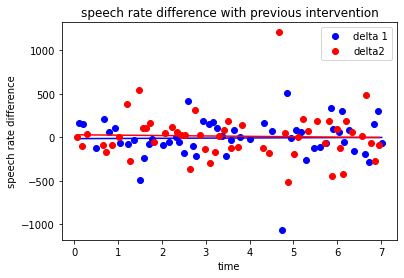

AA-MG-CH


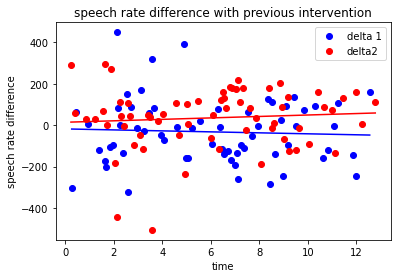

AA-MJ-CJ


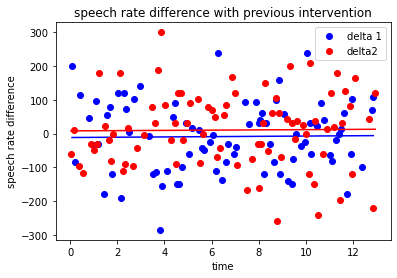

AA-JL-AZ


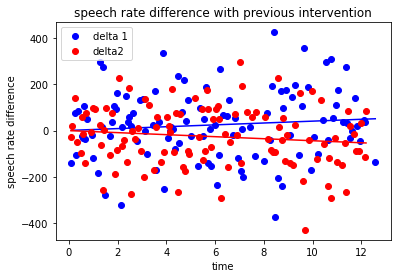

AA-BO-CM


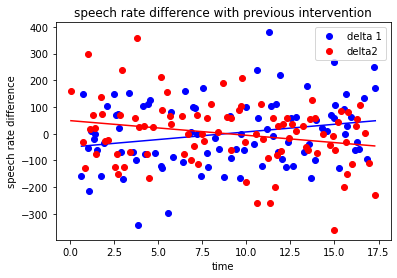

AA-GD-DD


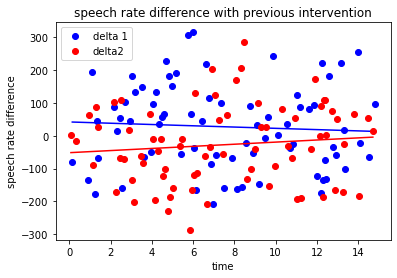

AA-XA-EH


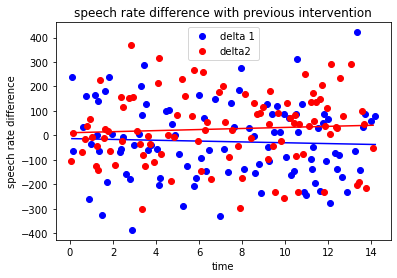

AA-AN-DL


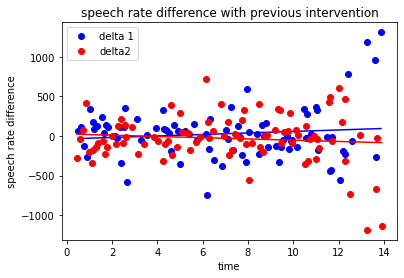

AA-ML-MP


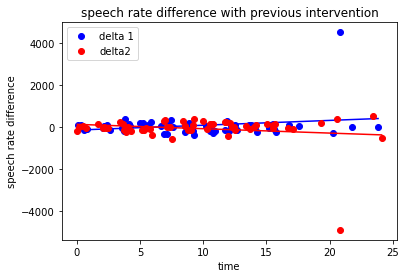

AA-LA-AN


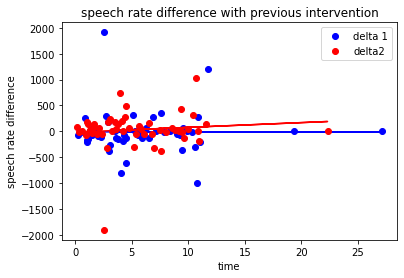

In [26]:
for k, df_delta_AA in enumerate(DF_DELTA_AA):
    
    conversation = data_AA[k]
    
    #for speaker 1
    
    linear_reg_1 = LinearRegression(normalize=True)
    
    x_1 = np.array((df_delta_AA[df_delta_AA['speaker']==0]['time']))
    x_1 = x_1.reshape(-1, 1)

    y_1 = np.array(df_delta_AA[df_delta_AA['speaker']==0]['delta'])
    y_1 = y_1.reshape(-1,1)
    
    linear_reg_1.fit(x_1, y_1)
    
    a_1 = linear_reg_1.coef_[0][0]
    b_1 = linear_reg_1.intercept_[0]
    
    #for speaker 2
    
    linear_reg_2 = LinearRegression(normalize=True)
    
    x_2 = np.array(df_delta_AA[df_delta_AA['speaker']==1]['time'])
    x_2 = x_2.reshape(-1,1)

    y_2 = np.array(df_delta_AA[df_delta_AA['speaker']==1]['delta'])
    y_2 = y_2.reshape(-1,1)
    
    linear_reg_2.fit(x_2, y_2)
    
    a_2 = linear_reg_2.coef_[0][0]
    b_2 = linear_reg_2.intercept_[0]
    
    
    print(file_names_AA[k])
    
    plt.figure()
    
    plt.plot(x_1, y_1, "bo",label="delta 1")
    plt.plot(x_1, a_1*x_1+b_1, color='b')
    
    plt.plot(x_2, y_2, "ro", label= "delta2")
    plt.plot(x_2, a_2*x_2+b_2, color='r')

    plt.xlabel('time')
    plt.ylabel('speech rate difference')
    plt.title('speech rate difference with previous intervention')
    plt.legend()
    plt.show()
    

In [278]:
%timeit

#parce que je fais beaucoup de boucles, flemme de réfléchir à plus efficace pour l'instant
#Maintenant on plot indifféremment du speaker, et on moyenne par minute sur toutes les conversations



speech_rate_diff = [] #un élément pour chaque minute
nb_points_per_min = []

time_step = 1  #en minute car le temps est en minute dans le DataFrame

for k, df_delta_AA in enumerate(DF_DELTA_AA):   #pour chaque conversation
    
    minute_max = int(df_delta_AA["time"][len(df_delta_AA["time"])-1]) +1 #(6 si on s'arrête à 5,5)
    
    for minute in range(minute_max):   #pour chaque minute
        nb_of_points = 0
        sum_speech_diff = 0
        
        i, time = 0, df_delta_AA["time"][0]
        while time < minute and i<len(df_delta_AA["time"])-1:
            i+=1
            time = df_delta_AA["time"][i]
        #now on est dans la minute qui nous intéresse
        while time < minute + 1 and i < len(df_delta_AA["time"])-1: #tant qu'on est dans cette minute
            sum_speech_diff += df_delta_AA['delta'][i]
            nb_of_points += 1
            i+=1
            time = df_delta_AA["time"][i]
        #on est sortis de la minute
        if len(speech_rate_diff) <= minute :       #si c'est une minute qu'on avait pas encore vue avec les conversations précédentes
            speech_rate_diff.append(sum_speech_diff)
            nb_points_per_min.append(nb_of_points)
        else:
            speech_rate_diff[minute] += sum_speech_diff #sinon, on somme juste
            nb_points_per_min[minute] += nb_of_points

speech_rate_diff = np.array(speech_rate_diff)
nb_points_per_min = np.array(nb_points_per_min)
speech_rate_diff = speech_rate_diff[nb_points_per_min != 0]
nb_points_per_min=nb_points_per_min[nb_points_per_min != 0]

mean_speech_rate_diff = [speech_rate_diff[i]/nb_points_per_min[i] for i in range(len(speech_rate_diff))]

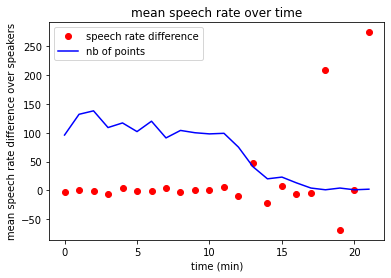

In [281]:
plt.figure()
plt.plot([i for i in range(len(mean_speech_rate_diff))], mean_speech_rate_diff, 'ro', label="speech rate difference")
plt.plot([i for i in range(len(nb_points_per_min))], nb_points_per_min, 'b', label="nb of points")
plt.xlabel("time (min)")
plt.ylabel("mean speech rate difference over speakers")
plt.title("mean speech rate over time")
plt.legend()
plt.show()

Pour CA maintenant

In [209]:
%time

for k,conversation in enumerate(data_CA):
    
    print(file_names_CA[k])

    speaker_list = []
    speaker1 = conversation['speaker'][0]
    for j in range(len(conversation['speaker'])):
        if conversation['speaker'][j]==speaker1:
            speaker_list.append(0)
        else:
            speaker_list.append(1)
    conversation['speaker'] = speaker_list


    ending_time = []
    for i in range(len(conversation['starting time'])-1):
        ending_time.append(conversation['starting time'][i+1])
    conversation.drop( conversation.tail(1).index, inplace = True )
    conversation['ending time'] = ending_time

    conversation['starting time'] = conversion_time(conversation['starting time'])
    conversation['ending time'] = conversion_time(conversation['ending time'])

    conversation['nb_syllables'] = [nb_syllables(conversation['words'][i]) for i in range(len(conversation['words']))]

    duration_list = []

    for i in range(len(conversation['starting time'])-1):
        if conversation['ending time'][i]-conversation['starting time'][i]==0:
            duration_list.append(np.mean(duration_list))
        else:
            duration_list.append(conversation['ending time'][i]-conversation['starting time'][i])
    duration_list.append(np.mean(duration_list))


    conversation['duration'] = duration_list
    
    speech_rate_list = []
    for i in conversation.index:
        speech_rate_list.append( conversation["nb_syllables"][i]/conversation['duration'][i] )
        
    conversation['speech rate'] = speech_rate_list
    conversation = conversation[ conversation['duration'] >= 0.01]  #on enlève les interventions trop courtes, donne un speech rate énorme

    data_CA[k] = conversation
    
    data_CA[k].reset_index(drop=True, inplace=True)


CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 14.3 µs
CA-XA-LA


/home/inous/anaconda3_2/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/inous/anaconda3_2/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


CA-MB-LB
CA-LJ-MJ
CA-MD-GD
CA-FB-MG
CA-RL-ML
CA-JL-JT
CA-LD-GD
CA-AN-ZN


In [210]:
#nom du fichier, indice du max speech rate, mots correspondants

for k, conversation in enumerate(data_CA):
    print(conversation.head())
    print(file_names_CA[k])
    print(max(conversation['speech rate']))
    print(conversation[ conversation['speech rate'] == max(conversation['speech rate']) ]['words'] )

   Unnamed: 0  speaker  starting time  \
0           1        1       0.116667   
1           2        0       0.133333   
2           3        1       0.566667   
3           4        0       0.616667   
4           6        0       0.733333   

                                               words  ending time  \
0                                              ouais     0.133333   
1    Okay. Kubra c'est tout bon pour vous là ? .....     0.566667   
2                                          umm, oui.     0.616667   
3    oui. Je vais pas te dire le mot mais tu vas ...     1.080067   
4                                        D 'accord ?     0.750000   

   nb_syllables  duration  speech rate  
0             1  0.016667    60.000000  
1            54  0.433333   124.615385  
2             2  0.050000    40.000000  
3            24  0.463400    51.791109  
4             3  0.016667   180.000000  
CA-XA-LA
1920.0000000001091
251      Là on a fait le temps que...  on a fait tout...
Name: w

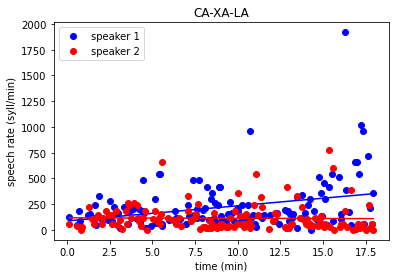

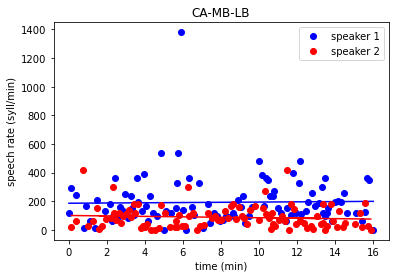

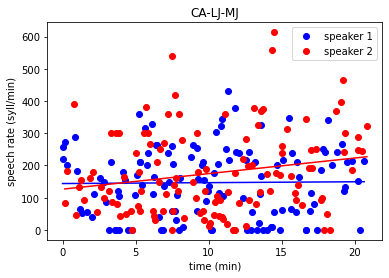

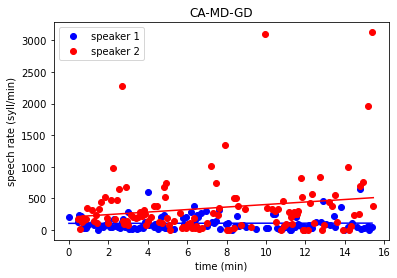

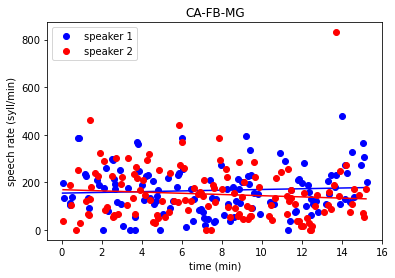

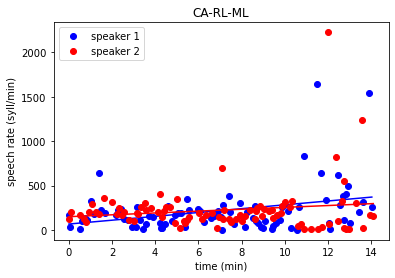

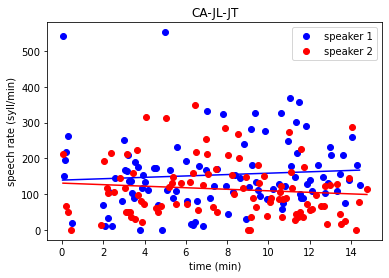

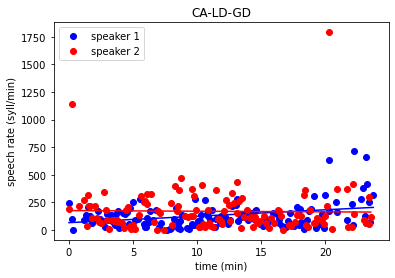

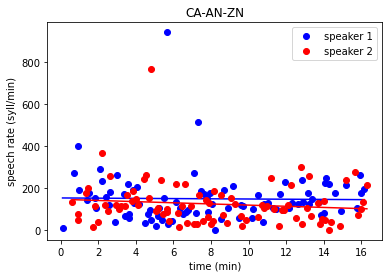

In [211]:
for k,conversation in enumerate(data_CA):

    #for speaker 1

    speech_1 = conversation[conversation['speaker']==0][['starting time', 'speech rate']]
    
    linear_reg_CA_1 = LinearRegression(normalize=True)
    
    x_1 = np.array(speech_1['starting time'])
    x_1 = x_1.reshape(-1,1)

    y_1 = np.array(speech_1['speech rate'])
    y_1 = y_1.reshape(-1,1)
    
    linear_reg_CA_1.fit(x_1, y_1)
    
    a_CA_1 = linear_reg_CA_1.coef_[0][0]
    b_CA_1 = linear_reg_CA_1.intercept_[0]
    
    #for speaker 2
    
    speech_2 = conversation[conversation['speaker']==1][['starting time', 'speech rate']]
    
    linear_reg_CA_2 = LinearRegression(normalize=True)
    
    x_2 = np.array(speech_2['starting time'])
    x_2 = x_2.reshape(-1,1)

    y_2 = np.array(speech_2['speech rate'])
    y_2 = y_2.reshape(-1,1)
    
    linear_reg_CA_2.fit(x_2, y_2)
    
    a_CA_2 = linear_reg_CA_2.coef_[0][0]
    b_CA_2 = linear_reg_CA_2.intercept_[0]

    plt.figure()
    plt.xlabel('time (min)')
    plt.ylabel('speech rate (syll/min)')
    plt.title(str(file_names_CA[k]))
    
    plt.plot(speech_1['starting time'], speech_1['speech rate'], 'o', color = 'b', label = 'speaker 1')
    plt.plot(speech_1['starting time'], a_CA_1 * speech_1['starting time'] + b_CA_1, color = 'b' )

    plt.plot(speech_2['starting time'], speech_2['speech rate'], 'o', color = 'r', label = 'speaker 2')
    plt.plot(speech_2['starting time'], a_CA_2 * speech_2['starting time'] + b_CA_2, color = 'r' )

    plt.legend()
    plt.show()

AA-LD-BF


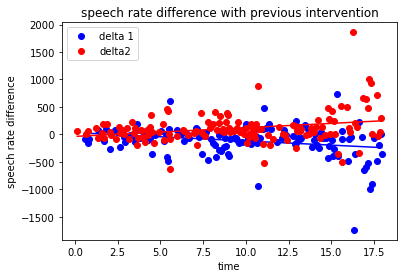

AA-MG-CH


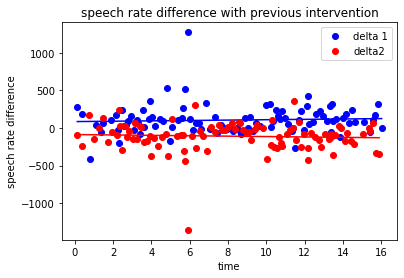

AA-MJ-CJ


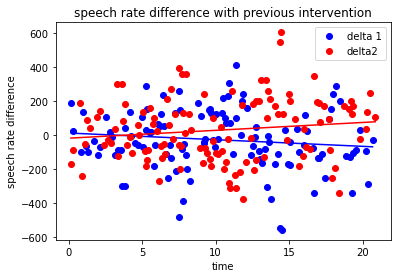

AA-JL-AZ


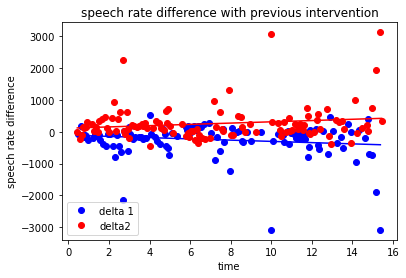

AA-BO-CM


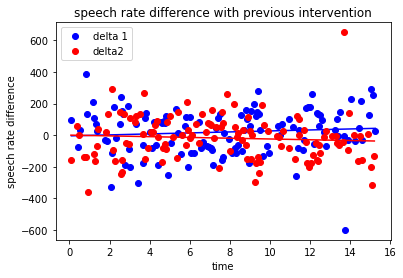

AA-GD-DD


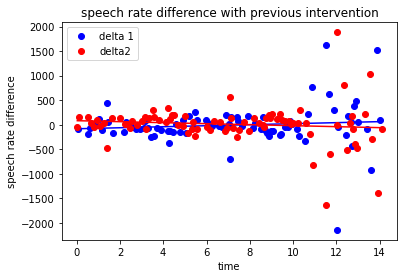

AA-XA-EH


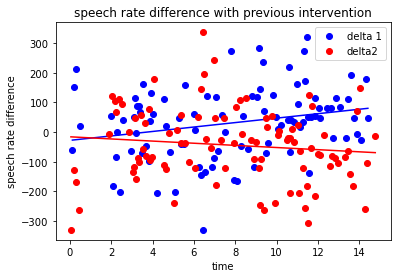

AA-AN-DL


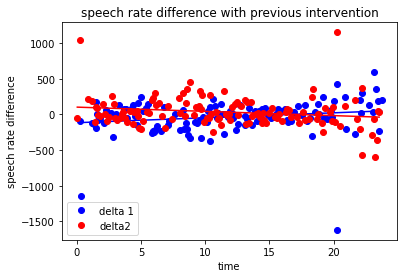

AA-ML-MP


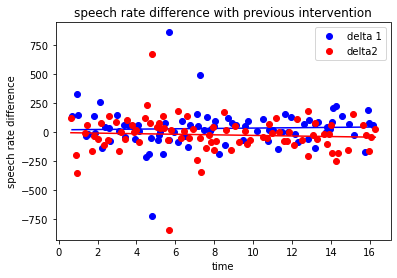

In [212]:
for k, conversation in enumerate(data_CA):
    
    index_1, diff_1, index_2, diff_2 = compute_difference_speech_rate(conversation)
    
    #for speaker 1
    
    linear_reg_1 = LinearRegression(normalize=True)
    
    x_1 = np.array(conversation.loc[index_1]['starting time'])
    x_1 = x_1.reshape(-1,1)

    y_1 = np.array(diff_1)
    y_1 = y_1.reshape(-1,1)
    
    linear_reg_1.fit(x_1, y_1)
    
    a_1 = linear_reg_1.coef_[0][0]
    b_1 = linear_reg_1.intercept_[0]
    
    #for speaker 2
    
    linear_reg_2 = LinearRegression(normalize=True)
    
    x_2 = np.array(conversation.loc[index_2]['starting time'])
    x_2 = x_2.reshape(-1,1)

    y_2 = np.array(diff_2)
    y_2 = y_2.reshape(-1,1)
    
    linear_reg_2.fit(x_2, y_2)
    
    a_2 = linear_reg_2.coef_[0][0]
    b_2 = linear_reg_2.intercept_[0]
    
    
    print(file_names_AA[k])
    
    plt.figure()
    
    plt.plot(conversation.loc[index_1]['starting time'], diff_1, "bo",label="delta 1")
    plt.plot(x_1, a_1*x_1+b_1, color='b')
    
    plt.plot(conversation.loc[index_2]["starting time"], diff_2, "ro", label= "delta2")
    plt.plot(x_2, a_2*x_2+b_2, color='r')

    plt.xlabel('time')
    plt.ylabel('speech rate difference')
    plt.title('speech rate difference with previous intervention')
    plt.legend()
    plt.show()
    

In [273]:
liste1 = [0,1,2,3,4,5,6]
liste2 = ['oui', 'non', 'oui', 'non', 'oui', 'non', 'oui']

TypeError: unsupported operand type(s) for %: 'list' and 'int'